In [1]:
!pip install -q torchinfo
!pip install einops
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

#Código

##Data

In [2]:
from datasets import load_dataset

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchinfo import summary
from einops import rearrange, repeat
import os
import pickle
import random

In [5]:
ds = load_dataset("ylecun/mnist")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Define a transform to convert PIL images to tensors
stats = ((0.1307),(0.3081))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)  # Convert PIL Image to PyTorch Tensor
])

# Update the datasets to use the transform
train_dataset = ImageDataset(ds['train'], transform=transform)
valid_dataset = ImageDataset(ds['test'], transform=transform)

In [7]:
Batch_size = 500

In [8]:
train_dl = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=Batch_size, shuffle=False, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Check device

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
device = get_default_device()
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

##Base

In [12]:
def funcion_perdida(x, xrec, mu, logvar, alpha = 1):
  ecm = F.mse_loss(x, xrec, reduction='sum')
  kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
  perdida = ecm + kl
  return perdida * alpha

In [13]:
class Base(nn.Module):

    def training_step(self, batch):
        images,labels = batch
        out, _, mu, log_variance = self(images)
        loss = funcion_perdida(images, out, mu, log_variance)
        return loss

    def validation_step(self, images):
        out, _, mu, log_variance = self(images)
        loss = funcion_perdida(images, out, mu, log_variance)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

##Model

In [18]:
class VAE(Base):
    """
    VAE represents a Deep Convolutional variational autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim,
                 d_model):
        super(VAE, self).__init__()

        self.input_shape = input_shape #28
        self.conv_filters = conv_filters # (28, 32, 64, 64)
        self.conv_kernels = conv_kernels # (3, 3, 3, 3)
        self.conv_strides = conv_strides # (1, 2, 2, 1)
        self.latent_space_dim = latent_space_dim # 2
        self.d_model = d_model
        self.reconstruction_loss_weight = 1000
        self.encoder = None
        self.decoder = None
        self.model = None

        self._model_input = None
        self.layers = nn.ModuleList()
        self.return_layers = nn.ModuleList()
        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self.num_neurons = 0
        self._build()



    #Creating VAE
    def _build(self):
        self._build_encoder()
        self._build_decoder()

    def _build_encoder(self):
        self.encoder = self._add_encoder_layers()
        self.bottleneck = self._add_bottleneck()
        self.return_layer = self._add_bottleneck_layer()

    def _add_bottleneck(self):
        self.mu = nn.Linear(self.d_model, self.latent_space_dim)
        self.log_variance = nn.Linear(self.d_model, self.latent_space_dim)
        return nn.Flatten()

    def _add_bottleneck_layer(self):
        return nn.Linear(self.latent_space_dim, self.d_model)

    def _build_decoder(self):
        self.decoder = self._add_decoder_layers()
        self.outputDecoder = self._add_output_layer()

    def _add_encoder_layers(self):
        in_channels = self.input_shape
        for out_channels, kernel_size, stride in zip( self.conv_filters,  self.conv_kernels, self.conv_strides):
            self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,padding=1))
            in_channels = out_channels
        return self.layers

    def _add_decoder_layers(self):#(28, 32, 64, 64) # (1, 2, 2, 1)
        in_channels = self.conv_filters[self._num_conv_layers-1]
        for index in reversed(range(1, self._num_conv_layers)):
              index_output = index - 1
              out = self.conv_strides[index] - 1
              self.return_layers.append(nn.ConvTranspose2d(self.conv_filters[index], self.conv_filters[index_output], self.conv_kernels[index], stride=self.conv_strides[index],padding=1,output_padding=out))
        return self.return_layers

    def _add_output_layer(self):
        return nn.ConvTranspose2d(self.conv_filters[0], 1, self.conv_kernels[0], stride=self.conv_strides[0],padding=1)

    #Compiling autoencoder
    def forward(self, x):
        for conv_layer in self.encoder:
            x = conv_layer(x)
            x = nn.ReLU()(x)
            x = nn.BatchNorm2d(x.shape[1]).to(x.device)(x)
        x = self.bottleneck(x) # self.mu, self.log_variance
        mu_x = self.mu(x)
        logver = self.log_variance(x)
        std = torch.exp(0.5 * logver)
        eps = torch.randn_like(std)
        projection = mu_x + eps * std
        x = projection #print(x.shape) torch.Size([500, 2])
        x = self.return_layer(x)
        x = x.view(-1, 64, 7, 7)
        for convT_layer in self.decoder:
            x = convT_layer(x)
            x = nn.ReLU()(x)
            x = nn.BatchNorm2d(x.shape[1]).to(x.device)(x)
        x = self.outputDecoder(x)
        x = nn.Sigmoid()(x)
        return x, projection, mu_x, logver

In [19]:
in_chanel= 1
out_channels = (32, 64, 64, 64)
Kernels = (3, 3, 3, 3)
strides = (1, 2, 2, 1)
letent_space = 2
d_model = 3136 # 7*7*64
model_ac = to_device(VAE(in_chanel, out_channels, Kernels, strides, letent_space, d_model), device)

##Training

In [ ]:
@torch.no_grad()
def evaluate(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch,labels in val_loader]
    return model_ac.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#metrics=[self._calculate_reconstruction_loss, self._calculate_kl_loss]
def try_model(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        outlist = []
        batchlist = []
        lrs = []

        for batch in train_loader:

            optimizer.zero_grad()
            loss = model.training_step(batch)
            train_losses.append(loss)

            loss.backward()

            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#epochs = 100
#max_lr = 0.001
#grad_clip = 0.0001
#weight_decay = 1e-4
#opt_func = torch.optim.Adam

epochs = 20
max_lr = 0.01
grad_clip = 0.0001
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(model_ac, train_dl)]
history

[{'val_loss': 538390.0}]

In [ ]:
history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl,weight_decay, grad_clip,
                             opt_func=opt_func)

Epoch [0], train_loss: 299621.2188, val_loss: 279368.7500
Epoch [1], train_loss: 277808.7188, val_loss: 280072.4062
Epoch [2], train_loss: 277617.2812, val_loss: 283410.9688
Epoch [3], train_loss: 281805.6875, val_loss: 286097.7812
Epoch [4], train_loss: 285909.9062, val_loss: 300252.7188
Epoch [5], train_loss: 295188.8750, val_loss: 293616.4688
Epoch [6], train_loss: 310469.2188, val_loss: 296892.8750
Epoch [7], train_loss: 296815.9375, val_loss: 336570.5938
Epoch [8], train_loss: 292103.7500, val_loss: 297667.5938
Epoch [9], train_loss: 290288.4062, val_loss: 286655.9688
Epoch [10], train_loss: 282889.4688, val_loss: 281420.5938
Epoch [11], train_loss: 279741.4688, val_loss: 280442.0000
Epoch [12], train_loss: 275435.2500, val_loss: 279525.7500
Epoch [13], train_loss: 273672.0625, val_loss: 276214.1562
Epoch [14], train_loss: 269532.1250, val_loss: 275540.9062
Epoch [15], train_loss: 266853.2500, val_loss: 272192.5625
Epoch [16], train_loss: 265034.9688, val_loss: 270335.5625
Epoch [

In [ ]:
save_path = "/content/drive/MyDrive/Data_AudioGen/weightsVAE.pth"
torch.save(model_ac.state_dict(), save_path)

##Analysis

In [20]:
saved_path = "/content/drive/MyDrive/Data_AudioGen/weightsVAE.pth"
weights = torch.load(saved_path,map_location=torch.device('cuda'))
model_ac.load_state_dict(weights)

<All keys matched successfully>

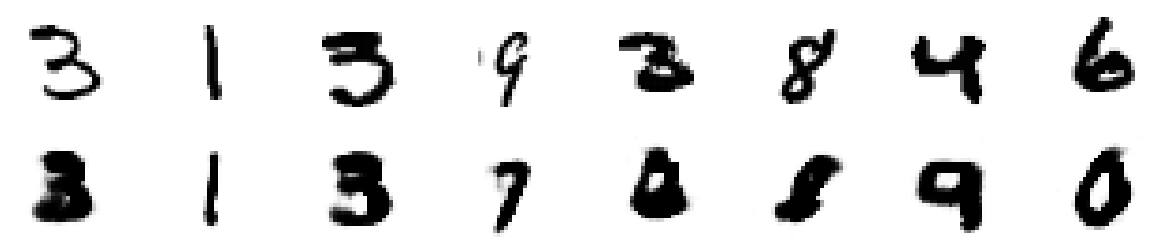

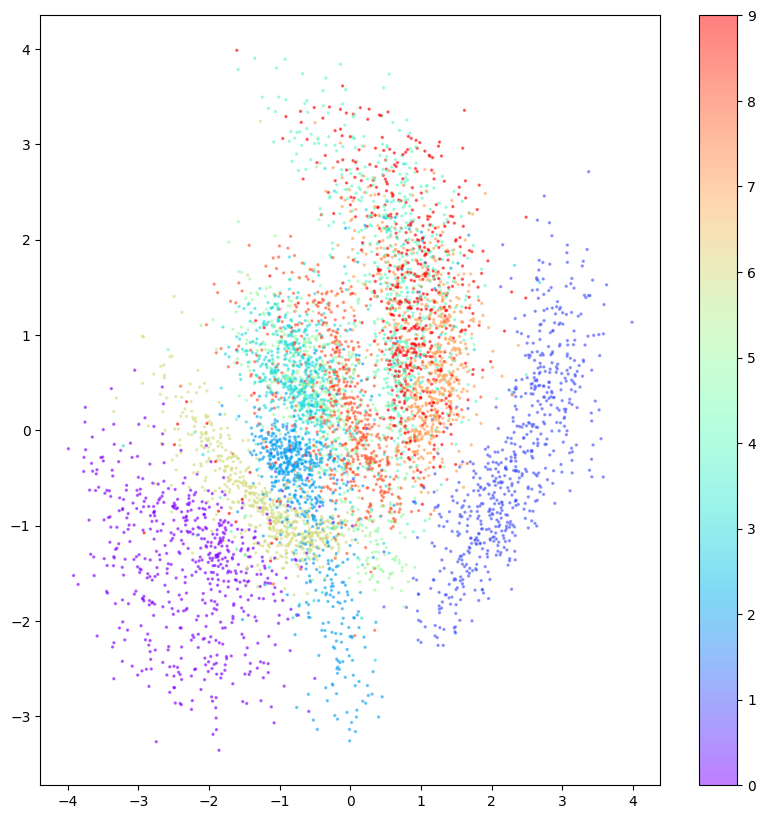

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def select_images(ds, num_images=10):
    indices = random.sample(range(len(ds['train'])), num_images)
    sampled_dataset = ds['train'].select(indices)
    sampled_dataset = ImageDataset(sampled_dataset, transform=transform)
    sampled_dataset = DataLoader(sampled_dataset, batch_size=num_images, shuffle=True, num_workers=3, pin_memory=True)
    return sampled_dataset

def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.cpu().squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

num_sample_images_to_show = 8
sample_images  = select_images(ds, num_sample_images_to_show)
sample_images = DeviceDataLoader(sample_images, device)
for images,labels in sample_images:
  with torch.no_grad():
    reconstructed_images,_,_,_ = model_ac(images)
    plot_reconstructed_images(images.cpu(), reconstructed_images.cpu().numpy())

num_images = 6000
sample_images = select_images(ds, num_images)
for images,labels in sample_images:
  images = images.to(device)
  with torch.no_grad():
    _, latent_representations,_,_ = model_ac(images)
    plot_images_encoded_in_latent_space(latent_representations.cpu().numpy(), labels)